In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# 1. Preprocessing Data

In [2]:
# Load data
df = pd.read_csv("data/ilapak3/train.csv")
df['times'] = pd.to_datetime(df['times'])
df = df.sort_values(by='times').reset_index(drop=True)

# Pick just data 2025
# df = df[df["times"].dt.year == 2025]
df.head(5)

,times,Shift,Status,Suhu Sealing Vertikal Bawah (oC),Suhu Sealing Vertical Atas (oC),Suhu Sealing Horizontal Depan/Kanan (oC),Suhu Sealing Horizontal Belakang/Kiri (oC ),Counter Output (pack),Counter Reject (pack),Speed(rpm),...,Quality(%),OEE(%),Jaws Position,Doser Drive Enable,Sealing Enable,Machine Alarm,Downtime_sec,Output Time_sec,Total Time_sec,Condition
0,2024-01-29 15:15:08,2,1,199.2,234.1,234.2,199.2,0,0,0.0,...,0.0,0.0,1,0,0,0,0.0,6.0,6.0,0
1,2024-01-29 15:20:08,2,1,199.3,234.1,234.2,199.3,0,0,0.0,...,0.0,0.0,1,0,0,0,0.0,306.0,306.0,0
2,2024-01-29 15:25:08,2,1,199.2,234.1,234.3,199.1,0,0,0.0,...,0.0,0.0,1,0,0,0,0.0,606.0,606.0,0
3,2024-01-29 15:30:08,2,1,199.2,234.2,234.2,199.2,0,0,0.0,...,0.0,0.0,1,0,0,0,0.0,906.0,906.0,0
4,2024-01-29 15:35:08,2,1,199.2,234.1,234.2,199.3,0,0,0.0,...,0.0,0.0,1,0,0,0,0.0,1206.0,1206.0,0


In [3]:
df["Condition"].value_counts()

Condition
0    159357
1     23081
2      1833
Name: count, dtype: int64

# Features Engineering

### Times Columns

In [4]:
df["month"] = df["times"].dt.month
df["week"] = df["times"].dt.isocalendar().week
df["day"] = df["times"].dt.day
df["hour"] = df["times"].dt.hour
df["minute"] = df["times"].dt.minute
df.drop(columns=["times"], inplace=True)
df.head(2)

,Shift,Status,Suhu Sealing Vertikal Bawah (oC),Suhu Sealing Vertical Atas (oC),Suhu Sealing Horizontal Depan/Kanan (oC),Suhu Sealing Horizontal Belakang/Kiri (oC ),Counter Output (pack),Counter Reject (pack),Speed(rpm),Availability(%),...,Machine Alarm,Downtime_sec,Output Time_sec,Total Time_sec,Condition,month,week,day,hour,minute
0,2,1,199.2,234.1,234.2,199.2,0,0,0.0,100.0,...,0,0.0,6.0,6.0,0,1,5,29,15,15
1,2,1,199.3,234.1,234.2,199.3,0,0,0.0,100.0,...,0,0.0,306.0,306.0,0,1,5,29,15,20


### Diff in Sealing Vertical & Horizontal

In [5]:
df["diff_sealing_vertical"] = df["Suhu Sealing Vertical Atas (oC)"] - df["Suhu Sealing Vertikal Bawah (oC)"]
df["diff_sealing_horizontal"] = df["Suhu Sealing Horizontal Depan/Kanan (oC)"] - df["Suhu Sealing Horizontal Belakang/Kiri (oC )"]

df["diff_sealing_top_vertical"] = df["Suhu Sealing Vertical Atas (oC)"].diff().fillna(0)
df["diff_sealing_bottom_vertical"] = df["Suhu Sealing Vertikal Bawah (oC)"].diff().fillna(0)
df["diff_sealing_top_horizontal"] = df["Suhu Sealing Horizontal Depan/Kanan (oC)"].diff().fillna(0)
df["diff_sealing_bottom_horizontal"] = df["Suhu Sealing Horizontal Belakang/Kiri (oC )"].diff().fillna(0)

### Diff in Output & Reject

In [6]:
df["diff_output"] = df["Counter Output (pack)"] - df["Counter Reject (pack)"]
df['diff_counter_output'] = df['Counter Output (pack)'].diff().fillna(0)
df['diff_counter_reject'] = df['Counter Reject (pack)'].diff().fillna(0)

### Diff in Counter Time 

In [7]:
df["diff_output_time"] = df["Output Time_sec"].diff().fillna(0)

<Axes: >

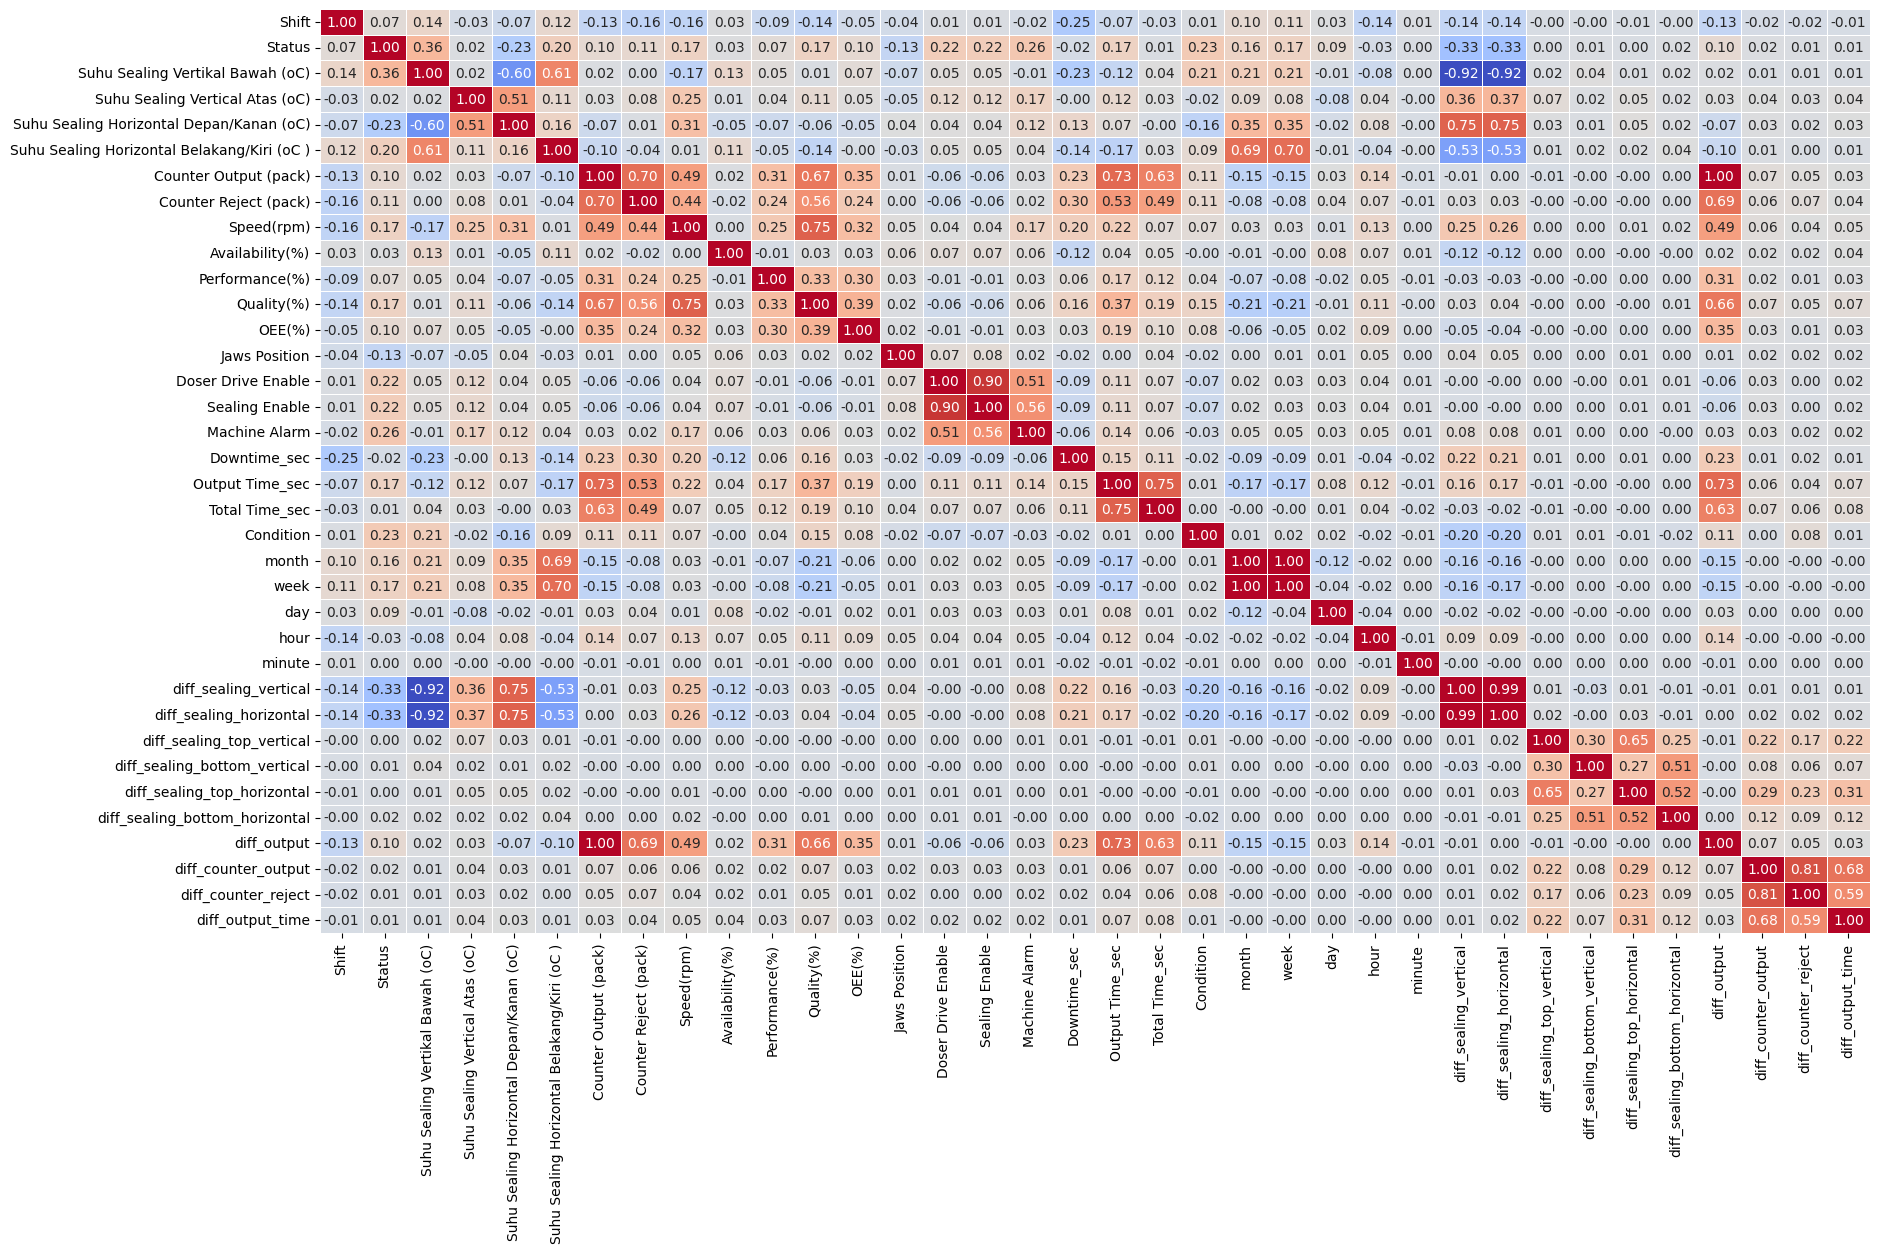

In [8]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Over Sampling
To handle imbalanced data best practice is to make it balanced.

In [9]:
categorical_cols = ['Status', 'Jaws Position', 'Doser Drive Enable', 'Sealing Enable', 'Machine Alarm', 'day', 'hour', 'minute']

continuous_cols = ['Suhu Sealing Vertikal Bawah (oC)', 'Suhu Sealing Vertical Atas (oC)',
                   'Suhu Sealing Horizontal Depan/Kanan (oC)', 'Suhu Sealing Horizontal Belakang/Kiri (oC )',
                   'Counter Output (pack)', 'Counter Reject (pack)', 'Speed(rpm)', 'Availability(%)',
                   'Performance(%)', 'Quality(%)', 'OEE(%)', 'Downtime_sec', 'Output Time_sec', 'diff_sealing_vertical', 
                   'diff_sealing_horizontal', 'diff_output', 'diff_counter_reject', 'diff_output_time']

target_col = "Condition"

In [10]:
X = df[categorical_cols + continuous_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create Pipeline

In [11]:
SEED = 42

num_data = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("encoder", PowerTransformer())
])

cat_data = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
])

preprocessor = ColumnTransformer([
    ("numerical", num_data, continuous_cols),
    ("categorical", cat_data, categorical_cols)
])

model = Pipeline([
    ("prep", preprocessor),
    ("algo", LGBMClassifier(
        random_state=SEED, 
        n_jobs=-1, 
        objective="multiclass", 
        num_class=len(y_train.value_counts()),
        n_estimators=238,
        learning_rate=np.float64(0.09607143064099162),
        max_depth=13,
        num_leaves=40,
        min_child_samples=81,
        subsample=np.float64(0.5780093202212182),
        colsample_bytree=np.float64(0.6872700594236812),
        reg_alpha=np.float64(0.03),                        
        reg_lambda=np.float64(0.03),  
    ))
])

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('encoder',
                                                                   PowerTransformer())]),
                                                  ['Suhu Sealing Vertikal '
                                                   'Bawah (oC)',
                                                   'Suhu Sealing Vertical Atas '
                                                   '(oC)',
                                                   'Suhu Sealing Horizontal '
                                                   'Depan/Kanan (oC)',
                                                   'Suhu Sealing Horizontal '
                                                   'Belakang/Kiri (oC )',
                                                   'Counter Output (pack)',
                                                   'Counter Reject (pack)',
                                                   'Speed(rpm)...
                                                   'hour', 'minute'])])),
                ('algo',
                 LGBMClassifier(colsample_bytree=np.float64(0.6872700594236812),
                                learning_rate=np.float64(0.09607143064099162),
                                max_depth=13, min_child_samples=81,
                                n_estimators=238, n_jobs=-1, num_class=3,
                                num_leaves=40, objective='multiclass',
                                random_state=42, reg_alpha=np.float64(0.03),
                                reg_lambda=np.float64(0.03),
                                subsample=np.float64(0.5780093202212182)))])

# Training

In [12]:
model.fit(X_train, y_train)

print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Validation accuracy: {model.score(X_val, y_val)}")

/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4118
[LightGBM] [Info] Number of data points in the train set: 165843, number of used features: 25
[LightGBM] [Info] Start training from score -0.145432
[LightGBM] [Info] Start training from score -2.076666
[LightGBM] [Info] Start training from score -4.604827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training accuracy: 0.9384357494739
Validation accuracy: 0.918113739960929


/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Evaluation

In [13]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score, log_loss
)
from sklearn.preprocessing import label_binarize

# Predictions
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

# Labels
labels = np.unique(y_val)
class_names = ["Normal", "Warning", "Leak"]

/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### 1. Classification Report

In [14]:
print(classification_report(y_val, y_pred, target_names=class_names, digits=2))

              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     15961
     Warning       0.85      0.42      0.56      2293
        Leak       0.66      0.66      0.66       174

    accuracy                           0.92     18428
   macro avg       0.81      0.69      0.72     18428
weighted avg       0.91      0.92      0.91     18428



### 2. Confusion Matrix

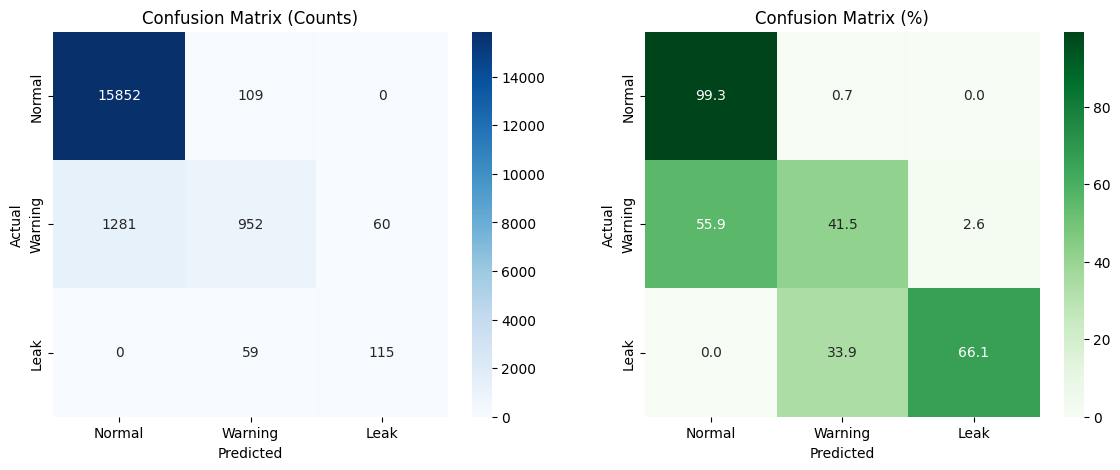

In [15]:
cm = confusion_matrix(y_val, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title('Confusion Matrix (Counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(cm_percent * 100, annot=True, fmt='.1f', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title('Confusion Matrix (%)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.show()

### 3. Per-class Acurracy

In [16]:
for i, label in enumerate(class_names):
    acc = cm[i, i] / cm[i].sum()
    print(f"{label}: {acc:.2%}")

Normal: 99.32%
Leak: 66.09%


### 4. Overall Accuracy

In [17]:
overall_acc = accuracy_score(y_val, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.2%}")


Overall Accuracy: 91.81%


### 5. Log loss

In [18]:
logloss = log_loss(y_val, y_proba)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.1819


### 6. ROC-AUC 

ROC AUC Score (OvR): 0.9777


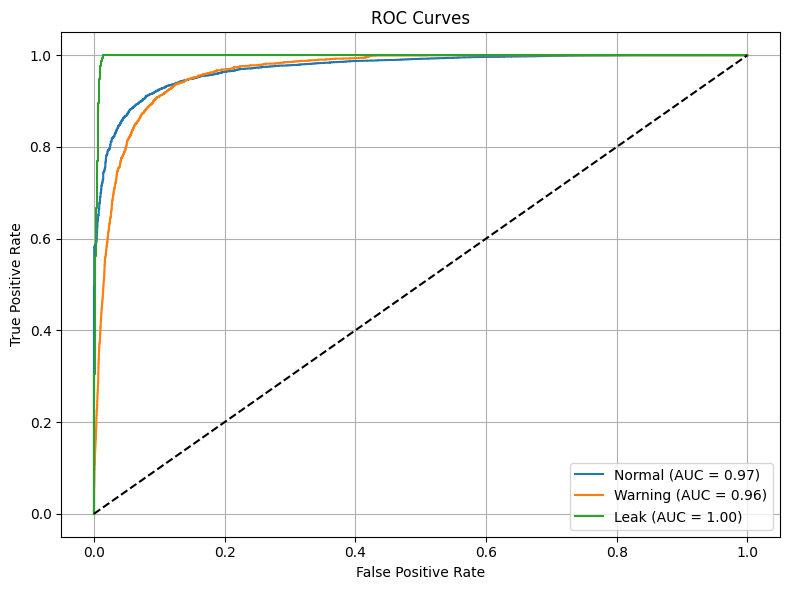

In [19]:
y_val_bin = label_binarize(y_val, classes=labels)
roc_auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_score(y_val_bin[:, i], y_proba[:, i]):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Features Importance

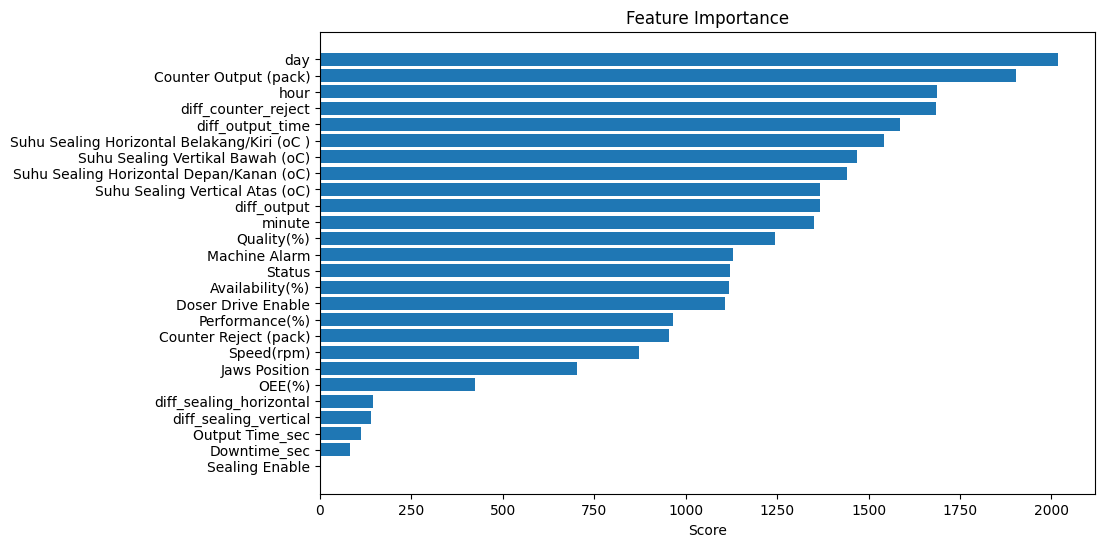

In [20]:
feature_importance = model["algo"].feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importance)
feature_names = feature_names[sorted_idx]
feature_importance = feature_importance[sorted_idx]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Score')
plt.title('Feature Importance')
plt.show()

In [21]:
feature_names[feature_importance > 930].shape

(18,)

# Re-Train

In [ ]:
continuous_cols = ['Suhu Sealing Vertikal Bawah (oC)',
                    'Suhu Sealing Horizontal Depan/Kanan (oC)', 'Status', 'OEE(%)',
                    'diff_counter_output', 'minute', 'diff_output_time', 'Jaws Position',
                    'Suhu Sealing Vertical Atas (oC)', 'Availability(%)', 'Speed(rpm)',
                    'Quality(%)', 'hour',
                    'Suhu Sealing Horizontal Belakang/Kiri (oC )', 'diff_counter_reject',
                    'Performance(%)', 'day', 'Counter Output (pack)'
                ]
categorical_cols = ['Doser Drive Enable', 'Machine Alarm']
target_col = "Condition"

SEED = 42

num_data = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("encoder", PowerTransformer())
])

cat_data = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
])

preprocessor = ColumnTransformer([
    ("numerical", num_data, continuous_cols),
    ("categorical", cat_data, categorical_cols)
])

model = Pipeline([
    ("prep", preprocessor),
    ("algo", LGBMClassifier(
        random_state=SEED, 
        n_jobs=-1, 
        objective="multiclass", 
        num_class=len(y_train.value_counts()),
        n_estimators=238,
        learning_rate=np.float64(0.09607143064099162),
        max_depth=13,
        num_leaves=40,
        min_child_samples=81,
        subsample=np.float64(0.5780093202212182),
        colsample_bytree=np.float64(0.6872700594236812),
        reg_alpha=np.float64(0.03),                        
        reg_lambda=np.float64(0.03),  
    ))
])

model

In [ ]:
model.fit(X_train, y_train)

print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Validation accuracy: {model.score(X_val, y_val)}")

In [ ]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

# Labels
labels = np.unique(y_val)
class_names = ["Normal", "Warning", "Leak"]

print(classification_report(y_val, y_pred, target_names=class_names, digits=2))

In [ ]:
cm = confusion_matrix(y_val, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title('Confusion Matrix (Counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(cm_percent * 100, annot=True, fmt='.1f', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title('Confusion Matrix (%)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.show()

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'ilapak3_model.pkl')

# Testing in Data Testing

In [ ]:
df_test = pd.read_csv("data/ilapak3/test.csv")
df_test['times'] = pd.to_datetime(df_test['times'])
df_test = df_test.sort_values(by='times').reset_index(drop=True)

df_test.head()

In [ ]:
df_test["minute"] = df_test["times"].dt.minute
df_test["hour"] = df_test["times"].dt.hour
df_test["day"] = df_test["times"].dt.day

df_test["diff_sealing_vertical"] = df_test["Suhu Sealing Vertical Atas (oC)"] - df_test["Suhu Sealing Vertikal Bawah (oC)"]
df_test["diff_sealing_horizontal"] = df_test["Suhu Sealing Horizontal Depan/Kanan (oC)"] - df_test["Suhu Sealing Horizontal Belakang/Kiri (oC )"]

df_test["diff_sealing_top_vertical"] = df_test["Suhu Sealing Vertical Atas (oC)"].diff().fillna(0)
df_test["diff_sealing_bottom_vertical"] = df_test["Suhu Sealing Vertikal Bawah (oC)"].diff().fillna(0)
df_test["diff_sealing_top_horizontal"] = df_test["Suhu Sealing Horizontal Depan/Kanan (oC)"].diff().fillna(0)
df_test["diff_sealing_bottom_horizontal"] = df_test["Suhu Sealing Horizontal Belakang/Kiri (oC )"].diff().fillna(0)

df_test["diff_output"] = df_test["Counter Output (pack)"] - df_test["Counter Reject (pack)"]
df_test['diff_counter_output'] = df_test['Counter Output (pack)'].diff().fillna(0)
df_test['diff_counter_reject'] = df_test['Counter Reject (pack)'].diff().fillna(0)

df_test["diff_output_time"] = df_test["Output Time_sec"].diff().fillna(0)

X_test = df_test[categorical_cols + continuous_cols]
y_test = df_test["Condition"]

In [ ]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)


In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title('Confusion Matrix (Counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(cm_percent * 100, annot=True, fmt='.1f', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title('Confusion Matrix (%)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.show()